<a href="https://colab.research.google.com/github/smomtahe/RNN/blob/main/RNN_Predict_Stock_Price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# RNN  predict stock prices for the next day based on the time series patterns observed for the previous days
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(1)

prices=pd.read_csv("https://raw.githubusercontent.com/smomtahe/RNN/main/stock-prices.csv") # 2 column: data and price


In [10]:
print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


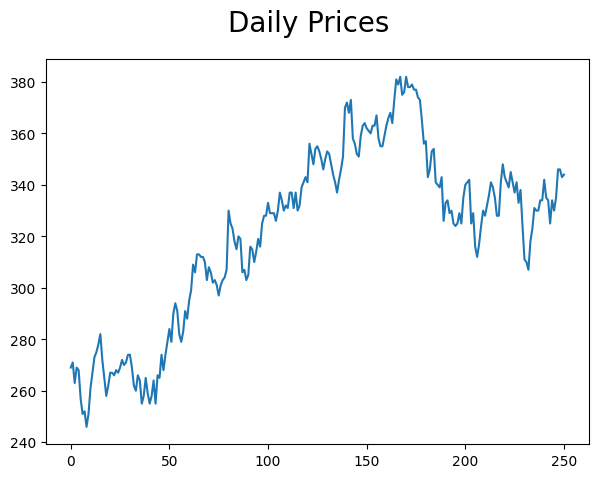

In [20]:
import matplotlib.pyplot as plt

# plot data to see the stock prices
# X: date points Y: prices
plt.figure(figsize=(7, 5))
plt.suptitle("Daily Prices", fontsize=20)
plt.plot(prices["Price"])
plt.show()

In [43]:
# scale data using standard scaler
from sklearn.preprocessing import StandardScaler

# assuming 'prices' is my DataFrame
scaler = StandardScaler()
scaled_prices = scaler.fit_transform(prices[["Price"]].values)
print(scaled_prices.shape)


total_size = len(scaled_prices)
test_size = 50
train_size = total_size - test_size
#print(train_size, test_size)

# split data sequentially (not randomly)
training_prices = scaled_prices[:train_size, :]
test_prices = scaled_prices[train_size:, :]
print(training_prices.shape, test_prices.shape)


(251, 1)
(201, 1) (50, 1)


In [44]:
# Time series : predict next day (time step) from previous day (time steps)
 # 1 set sequence as training data and build a model to predict for the next day
 # goal: create multiple training samples (from a single input sequence of data) needed to train an RNN ; for each sample: target = value for the current time step and features = values for the previous time steps
 # X values in input sequence: 11 Y:Lookback= 5  11-5-1=5 samples
 # each data point X is linked to previous data points of size=lookback
 # predicted value Y is the next point
 # Lookback value = 5 (= # of previous time steps-> training data) -> create multiple samples from a single sequence as:
 # s1 (t1:F t2:F ... t5:F t6:T)
 # s2 (t2:F t3:F... t6:F t7:T) slide 1 step ahead
 #...
 # s5 (t5:F t6:F... t9:F t10:T)


In [49]:
# prepare RNN dataset
# data : input time series data and lookback specifies how many time steps back the RNN should look when creating each sample.
def create_run_dataset(data, lookback=1):
  data_x, data_y = [], []  # Initialize empty lists to store input sequences (data_x) and corresponding output values (data_y).

  for i in range(len(data) - lookback - 1):  # Iterate through the data to create samples for the RNN. The loop runs up to the index where it can create a complete sample.
    # all points from this point, looking backward up to lookback
    a = data[i:(i+lookback), 0]  # Extract a sequence of 'lookback' points starting from the current index 'i'.
    data_x.append(a)  # Append the extracted sequence to the data_x list.

    # the next point
    data_y.append(data[i + lookback, 0])  # Append the next point in the sequence (the point after the 'lookback' points) to the data_y list.

  return np.array(data_x), np.array(data_y)  # Convert the lists to NumPy arrays and return them.

#lookback for 25 previous days
lookback=25
train_reg_x,train_reg_y=create_run_dataset(training_prices, lookback)

train_reg_x=np.reshape(train_reg_x, (train_reg_x.shape[0],1, train_reg_x.shape[1]))
print("Shapes of X, Y:",train_reg_x.shape, train_reg_y.shape)
# 201 stock values - 25 -1 = 175 samples with a lookback of 25


Shapes of X, Y: (175, 1, 25) (175,)


175

In [58]:
#keras models
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.layers import LSTM
import tensorflow as tf
tf.random.set_seed(3)

model = Sequential()
model.add(SimpleRNN(32, input_shape=(1,lookback))) # total number of nodes : 32
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])
model.summary()

# train the model
model.fit(train_reg_x, train_reg_y,epochs=5,batch_size=1,verbose=1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_5 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
175/175 [==============================] - 2s 3ms/step - loss: 0.1893 - mse: 0.1893
Epoch 2/5
175/175 [==============================] - 1s 3ms/step - loss: 0.0469 - mse: 0.0469
Epoch 3/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0439 - mse: 0.0439
Epoch 4/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0372 - mse: 0.0372
Epoch 5/5
175/175 [=======================

In [63]:
# test the model
test_reg_x,test_reg_y=create_run_dataset(test_prices,lookback)
print(test_reg_x.shape,test_reg_y.shape)

test_reg_x=np.reshape(test_reg_x,(test_reg_x.shape[0],1,test_reg_x.shape[1] ))
model.evaluate(test_reg_x,test_reg_y,verbose=1)
predict_test=model.predict(test_reg_x)
predict_test=scaler.inverse_transform(predict_test) # back to original scale

(24, 25) (24,)
1/1 [==============================] - 1s 619ms/step


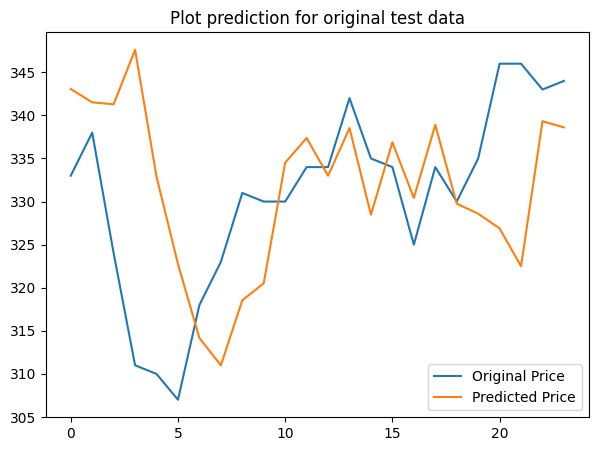

In [65]:
# visualize the data
import matplotlib.pyplot as plt

orig_test_values = prices[["Price"]].loc[total_size - len(predict_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(7, 5))
plt.subplot(1, 1, 1)  # Fix: Use 'plt.subplot()' instead of 'plt.subplot()'
plt.title("Plot prediction for original test data")  # Fix: 'title' instead of 'subplot'
plt.plot(orig_test_values, label='Original Price')
plt.plot(predict_test, label='Predicted Price')
plt.legend()  # Add a legend to distinguish between original and predicted prices
plt.show()


In [74]:
# previous prices
previous_prices = np.array([
    [325, 335, 340, 341, 342],
    [325, 339, 328, 312, 317],
    [324, 330, 328, 332, 336],
    [341, 348, 343, 341, 339],
    [341, 339, 335, 332, 328]
])
scaled_prices=scaler.transform(previous_prices.reshape(-1,1))
model_input=np.reshape(scaled_prices,(scaled_prices.shape[1],1,scaled_prices.shape[0]))
prediction=model.predict(model_input)
norm_prediction=scaler.inverse_transform(prediction)
print("predicted stock preice:" , norm_prediction[0][0] )

1/1 [==============================] - 0s 47ms/step
predicted stock preice: 326.38318
